## Summarize some optogenetics + imaging data

In [73]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from fish.util.plot import proj_fuse
%matplotlib inline

In [115]:
def make_cbar(ax, im):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.pyplot import colorbar
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = colorbar(im, cax=cax)
    return cbar


In [40]:
## compare pre stim and post stim for dmd-optogenetics data
base_dirs = ('/groups/ahrens/ahrenslab/davis/data/spim/proc/20180314/f1/5dpf_gfap_h2b_gcamp_x_huc_rgeco_x_ec43_opto_1_20180314_124124/',
             '/groups/ahrens/ahrenslab/davis/data/spim/proc/20180314/f1/5dpf_gfap_h2b_gcamp_x_huc_rgeco_x_ec43_opto_2_20180314_161038/')

tr_medians = [[],[]]
for ind, bd in enumerate(base_dirs):
    tr_medians[ind] = [imread(bd+'opto/trial_median_condition_{0}.tif'.format(cond)) for cond in (0,1)]

In [120]:
np.arange(20,29) / fs_im

array([ 10.25641026,  10.76923077,  11.28205128,  11.79487179,
        12.30769231,  12.82051282,  13.33333333,  13.84615385,  14.35897436])

[(-0.5, 1269.5, -0.5, 757.5), (-0.5, 1269.5, -0.5, 757.5)]

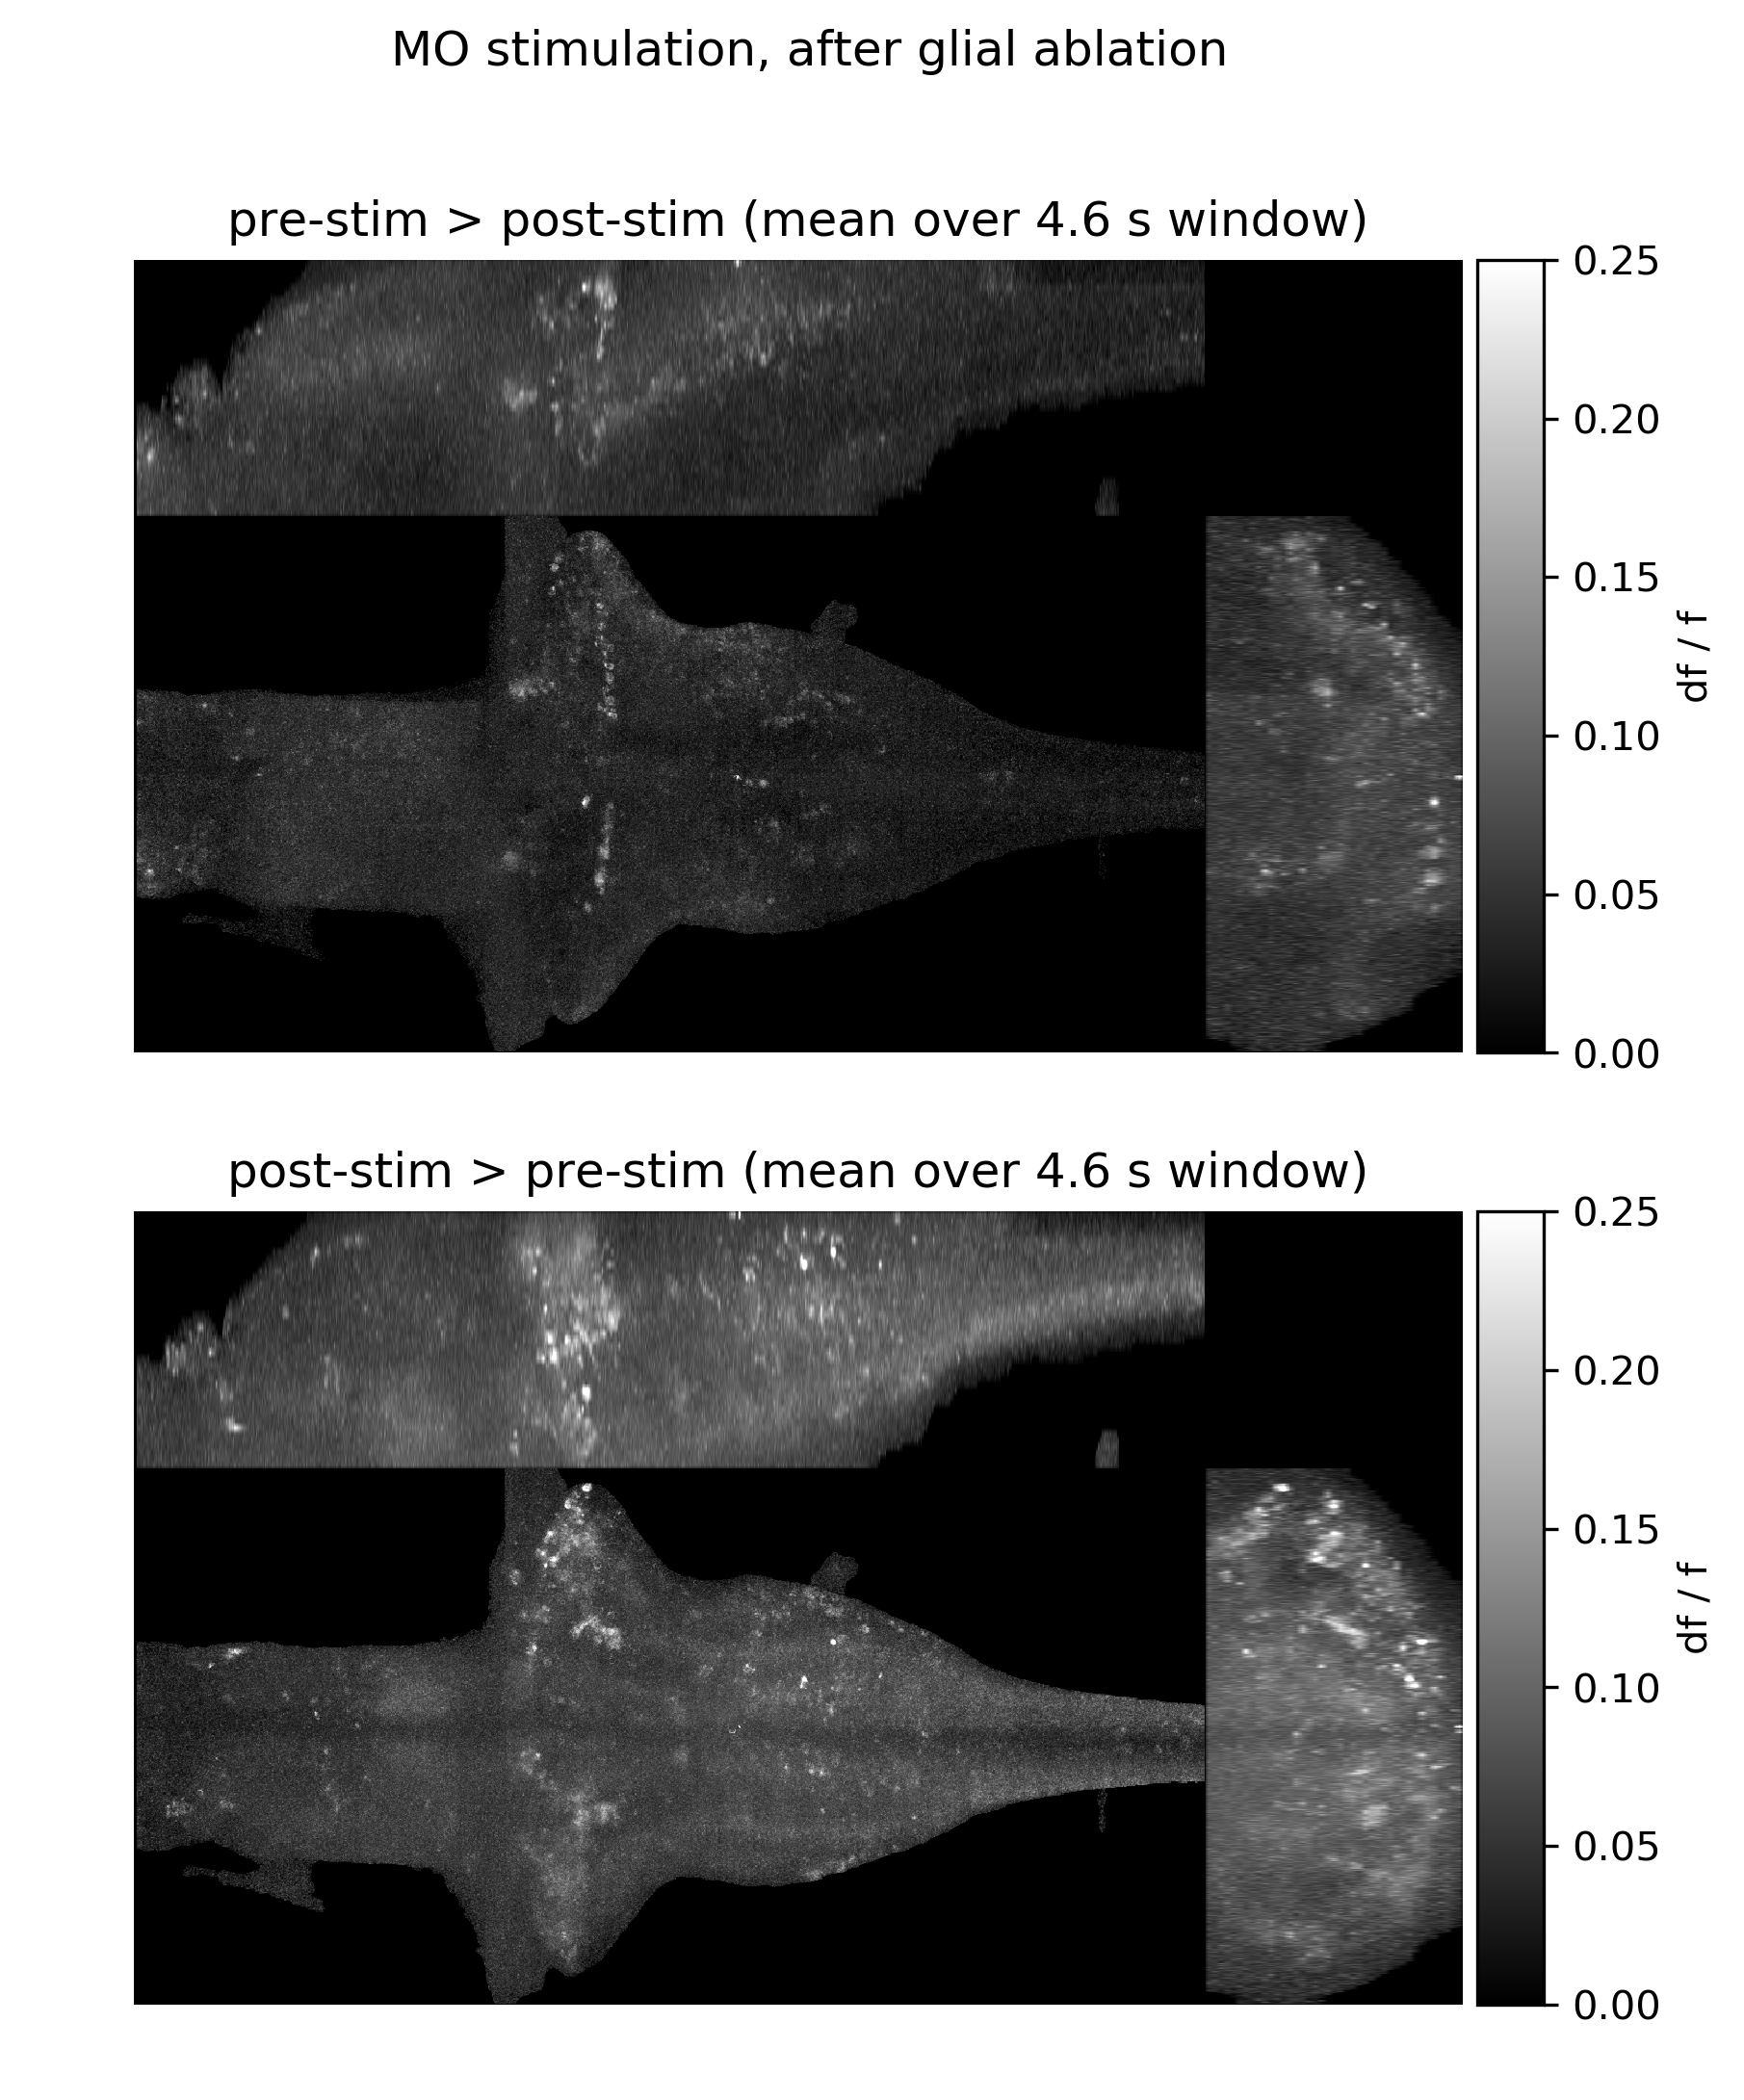

In [119]:
title = 'MO stimulation, after glial ablation'
pre = tr_medians[1][1]
mx = (pre[w_[0]].mean(0) - pre[w_[1]].mean(0))
mn = (pre[w_[1]].mean(0) - pre[w_[0]].mean(0))

aspect= (6,1,1)
fig, axs= plt.subplots(nrows=2, figsize=(8,8), dpi=300)
fig.suptitle(title)

fs_im = 1.95
w_ = (np.arange(0,9), np.arange(20, 29))

im_ = axs[0].imshow(proj_fuse(mx, np.max, aspect=aspect), cmap='gray', clim=(0,.25), origin='lower')
axs[0].title.set_text('pre-stim > post-stim (mean over {0:.1f} s window)'.format(len(w_[0]) / fs_im))
make_cbar(axs[0],im_).ax.set_ylabel('df / f')

im_ = axs[1].imshow(proj_fuse(mn, np.max, aspect=aspect), cmap='gray', clim=(0,.25), origin='lower')
axs[1].title.set_text('post-stim > pre-stim (mean over {0:.1f} s window)'.format(len(w_[0]) / fs_im))
make_cbar(axs[1],im_).ax.set_ylabel('df / f')
[ax.axis('off') for ax in axs]

In [96]:
from numpy import arange, linspace
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib qt
class NDV(object):
    def __init__(self, ax, data, **kwargs):
        self.fig = ax.get_figure()
        self.axs = {}
        self.axs['image'] = ax
        self.axs['sliders'] = []                
        self.imshow_kwargs = kwargs
        self.data = data
        self.imdims = [-2,-1]
        self.slider_dims = list(set(arange(self.data.ndim)) - set(arange(self.data.ndim)[self.imdims]))
        
        self._slider_span = ((.1, .9), (0, .05))
        self._slider_y = linspace(*self._slider_span[1], len(self.slider_dims))
        self._slider_x = [self._slider_span[0][0]] * len(self.slider_dims)
        self._slider_w = [self._slider_span[0][1] - self._slider_span[0][0]] * len(self.slider_dims)
        self._slider_h = [(self._slider_span[1][1] - self._slider_span[1][0]) / len(self.slider_dims)] * len(self.slider_dims)
        
        self.sliders = self._generate_sliders()
        self.slices = [0] * self.data.ndim

        for imd in self.imdims:
            self.slices[imd] = slice(None)
        
        self.im = ax.imshow(self.data[self.slices], **self.imshow_kwargs)
        self.update(0)
    
    def _generate_sliders(self): 
        self.axs['sliders'] = []
        sliders = []
        if self.data.ndim > 2:
            for ind_d, dim in enumerate(self.slider_dims):
                slpos = [self._slider_x[ind_d], self._slider_y[ind_d], self._slider_w[ind_d], self._slider_h[ind_d]]
                axs_sl = self.fig.add_axes(slpos)                
                slider = Slider(axs_sl, str(dim), valmin=0, valmax=self.data.shape[dim]-1, valinit=0, valfmt='%i')
                slider.on_changed(self.update)
                sliders.append(slider)
                self.axs['sliders'].append(axs_sl)
        return sliders
    
    def update_slices(self):
        for ind_d, dim in enumerate(self.slider_dims):
            self.slices[ind_d] = int(self.sliders[ind_d].val)
            #print('dim {0} : {1}'.format(dim, self.slices[ind_d]))
    
    def update(self,val):
        self.update_slices()
        self.im.set_data(self.data[self.slices])        
        self.fig.canvas.draw()

In [97]:
fig, ax = plt.subplots(figsize=(12,12), dpi=300)
data = np.random.rand(40,40,40, 40)
ndv = NDV(ax, data, cmap='gray')
plt.show()

In [1]:
## See how bad movement artifacts during optostim are

In [6]:
import numpy as np
from glob import glob
from fish.util.fileio import load_image
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
fnames = sorted(glob('/groups/ahrens/ahrenslab/davis/data/spim/raw/20171008/7dpf_cy171xec43_f2_opto_1_20171008_173349/TM*'))

In [54]:
from skimage.io import imread
ref = imread('/groups/ahrens/ahrenslab/davis/data/spim/proc/20171008/7dpf_cy171xec43_f2_opto_1_20171008_173349/reg/anat_reference.tif')

In [55]:
plr = slice(2000, 2200)
mxs = np.array([load_image(fn).max(0) for fn in fnames[plr]])

In [91]:
from fish.image.alignment import estimate_translation

In [95]:
%gui qt
import pyqtgraph as pq

In [98]:
pq.image(np.concatenate([moving, ref],1))

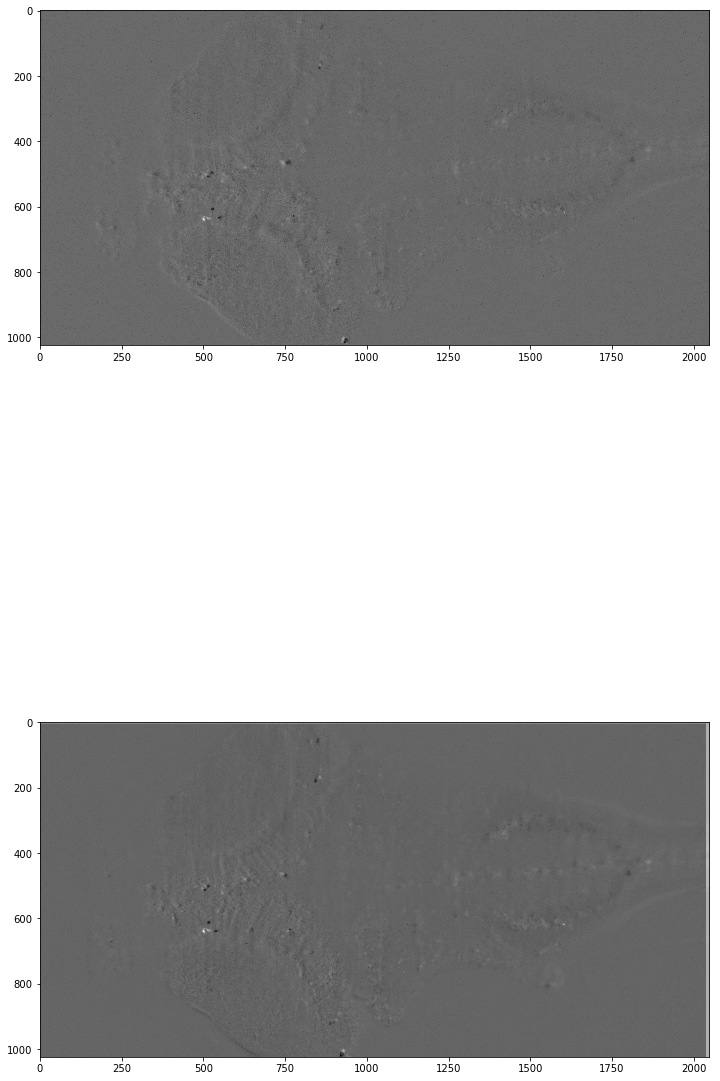

In [93]:
t = 2143
moving = load_image(fnames[t])
tx = estimate_translation(ref.max(0), moving.max(0))
fig, axs = plt.subplots(nrows=2, figsize=(12,24))
axs[0].imshow(ref.max(0) - moving.max(0), cmap='gray')
axs[1].imshow(ref.max(0) - tx.transform(moving.max(0)), cmap='gray')

In [1]:
## Reconstruct stimulated area from optostim experiments

In [1]:
from skimage.io import imread
paths = {}
paths['ephys'] = '/groups/ahrens/ahrenslab/davis/data/ephys/20171108/7dpf_cy171xec43_f1_opto_2_12mw.10chFlt'
paths['raw'] = '/groups/ahrens/ahrenslab/davis/data/spim/raw/20171108/7dpf_cy171xec43_f1_opto_2_12mw_20171108_215904/'
paths['proc'] = paths['raw'].replace('raw', 'proc')
paths['reg'] = paths['proc'] + 'reg/'
paths['opto'] = paths['proc'] + 'opto_triggering/'
mask = imread(paths['opto'] + 'mask.tif')


In [2]:
from glob import glob
import numpy as np
patterns = np.array([imread(f) for f in sorted(glob('/groups/ahrens/ahrenslab/davis/data/ephys/20171108/7dpf_cy171xec43_f1/*.png'))])
anat = imread('/groups/ahrens/ahrenslab/davis/data/dmd_calibration/20171108/7dpf_cy171xec43_f1_anat_g_20171108_212622/TM00000_CM0_CHN00.tif').max(0)
dmd_rect = [229, 575, 1822, 1456]

In [9]:
def rgba_from_binary(mask):
    from numpy import zeros
    from skimage.color import grey2rgb
    from skimage.exposure import rescale_intensity
    output = zeros([*mask.shape, 4])
    output[:,:,:3] = grey2rgb(rescale_intensity(mask, out_range=(0,1)))
    output[:,:,3] = output[:,:,0]
    return output

def reverse_pattern(pattern, dmd_rect):
    from skimage.transform import resize
    from numpy import zeros
    full_cam = zeros([2048,2048])
 
    pattern_shape = (dmd_rect[3] - dmd_rect[1], dmd_rect[2] - dmd_rect[0])    
    resized=resize(pattern[:,::-1], output_shape=pattern_shape, preserve_range=True, mode='constant')    
    full_cam[dmd_rect[1]:dmd_rect[3], dmd_rect[0]:dmd_rect[2]] = resized
        
    return full_cam

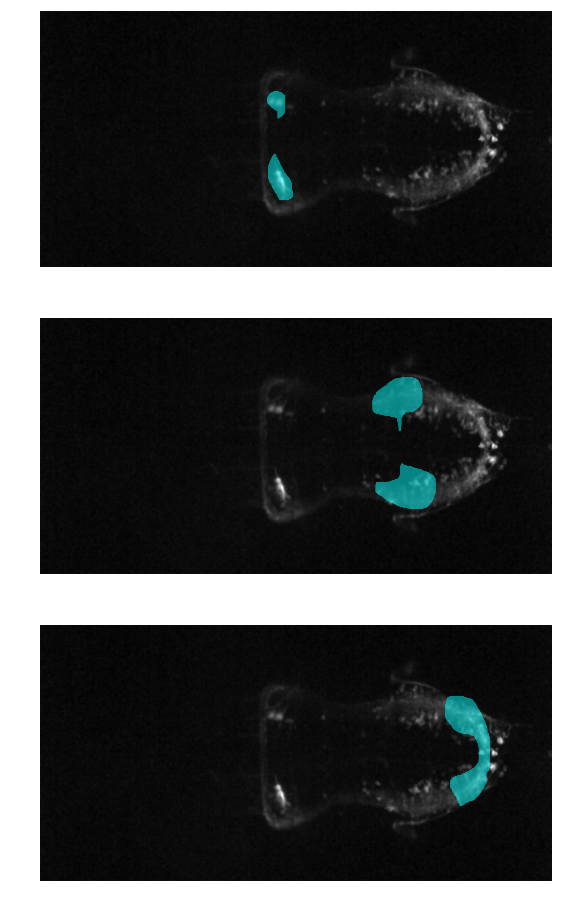

In [10]:
import matplotlib.pyplot as plt
from skimage.color import grey2rgb
from skimage.exposure import rescale_intensity
%matplotlib inline
anat_full = np.zeros([2048,2048,4])
from scipy.ndimage.filters import gaussian_filter
anat_filt = gaussian_filter(anat.astype('float'), [3,3])
anat_full[(2048//4):(3 * 2048 // 4),:,:3] = grey2rgb(rescale_intensity(anat_filt, out_range=(0,1)))
anat_full[:,:,-1] = 1
anat_full = adjust_gamma(anat_full, .8)
    
fig, axs = plt.subplots(nrows=patterns.shape[0], figsize=(16,16))
full_img = np.zeros(anat.shape)

from skimage.color import grey2rgb
from skimage.exposure import rescale_intensity
rgba_patterns = [rgba_from_binary(reverse_pattern(p, dmd_rect)) for p in patterns]
crop = (slice(2048 // 4, 3 * 2048 // 4), slice(0, None), slice(0, None))
for ind, ax in enumerate(axs):
    ax.imshow(anat_full[crop])
    ax.imshow(rgba_patterns[ind][crop] * np.array([0,1,1,.5]))
    ax.axis('off')